In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [3]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [4]:
import os
import shutil
from pathlib import Path
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts_gaussian import load_results

In [5]:
def clean_dir(path):
    paths_to_remove = []
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

### Data setup

In [6]:
flow = 1
fhigh = 50
scale_power = 3

gamma_load = pickle_open(f'../gammas/k2-flat{flow}-{fhigh}-{scale_power}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

In [ ]:
def trial_optimizer(trial, batch, gpi, p, obs_type):

    trial_data = batch[:,:,trial]
    cost_func = get_e_step_cost_func(trial_data, gpi, p, obs_type)
    cost_grad = jax.grad(cost_func, holomorphic=True)
    cost_hess = jax.hessian(cost_func, holomorphic=True)
    zs_est = zs_init

    for _ in range(max_iter):
        zs_hess = cost_hess(zs_est)
        hess_sel = jnp.stack([zs_hess[n,:,n,:] for n in range(Nnz)])
        hess_sel_inv = jnp.linalg.inv(hess_sel)

        zs_grad = cost_grad(zs_est).conj()
        zs_est = zs_est - jnp.einsum('nki,ni->nk', hess_sel_inv, zs_grad)
        _cost = cost_func(zs_est)
        # jax.debug.breakpoint()

    zs_est = zs_est.reshape((Nnz,K))
    mu_outer = jnp.einsum('nk,ni->nki', zs_est, zs_est.conj())

    if Ups_diag is True:
        Ups = hess_sel_inv*diag_mask
    else:
        Ups = hess_sel_inv

    if return_mus:
        return [zs_est, mu_outer], Ups
    else:
        return mu_outer, Ups


In [7]:
res_paths = ['batch_submit/outputs/2024-10-10']
# clean_dir(res_paths[0])
# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 50
init = 'flat-init'
emiters = 20
scale_init = 100000
ovs_sel = None

supp = [0, 50]
res_load = load_results(res_paths, ovs_sel, ts_flag=False, method=None, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# res_load_ts_jax = load_results(res_paths, ovs_sel, ts_flag=True, method='jax-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

# res_load_ts_old_scipy = load_results(res_paths, ovs_sel, ts_flag=True, method='scipy-old', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# res_load_ts_oldmod_scipy = load_results(res_paths, ovs_sel, ts_flag=True, method='scipy-oldmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

# res_load_ts_old_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='old-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init) res_load_ts_oldmod_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='oldmod-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [8]:
res_paths = ['outputs/2024-10-10']
new_res_load_ts_old_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='old-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
new_res_load_ts_oldmod_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='oldmod-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [9]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

dummy = -1 
old_model_load = load_old(dummy)
Wv = old_model_load['Wv']

In [10]:
# res_load_ts_oldmod_scipy.keys()
res_load.keys()

dict_keys([-1, 0, 2, 1])

In [21]:

ov2 = 1
r = 0
j = 19 
res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data.keys()
res_load_ts_oldmod_scipy[ov2]['track'][0][r]['Sig_complex'][0,j,:,:]

array([[ 9875.08729613   +0.j        , -1836.56777639+2109.65611099j],
       [-1836.56777639-2109.65611099j, 19540.66817424   +0.j        ]])

In [12]:
# res_load[ov2]['params']

In [13]:
def sample_obs(gamma, result):
    cfg = result['cfg']
    lcfg = cfg['latent']
    ocfg = cfg['obs']

    lrk = jr.key(lcfg.seed)
    ork = jr.key(ocfg.seed)
    L = lcfg.L
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    zs = sample_from_gamma(lrk, gamma, L)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    return obs

def sample_obs_for_qfunc_mc(gamma_r, result, M, mc_ork=0):
    "assumes gamma is complex"

    
    cfg = result['cfg']
    lcfg = cfg['latent']
    ocfg = cfg['obs']

    lrk = jr.key(lcfg.seed)
    L = lcfg.L
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2



    if gamma_r.shape[0] < result['gamma_true_full'].shape[0]:
        nz = result['params']['nonzero_inds']
        gamma_temp = jnp.zeros_like(result['gamma_true_full'])
        gamma_temp = gamma_temp.at[nz,:,:].set(gamma_r)
        gamma_r = gamma_temp

    zs = sample_from_gamma(lrk, gamma_r, L)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    rk_split = jr.split(mc_ork, M)

    obs_mc_samples = [xs + jr.normal(rk_split[i], xs.shape)*jnp.sqrt(obs_var) for i in range(M)]

    return obs_mc_samples



In [14]:
from cohlib.conv import reverse_rearrange_mat
def transform_mat_c2r(complex_mat):
    """
    Convert matariance matrix from complex-valued to real-valued.
    """
    dim = complex_mat.shape[0]
    A = jnp.real(complex_mat)
    B = jnp.imag(complex_mat)
    rmat = jnp.zeros((2 * dim, 2 * dim))

    rmat = jnp.block([[A, -B], [B, A]])

    return rmat 

def transform_cov_c2r(complex_cov):
    return transform_mat_c2r(complex_cov) / 2

def transform_inv_cov_c2r(complex_inv_cov):
    return 2*transform_mat_c2r(complex_inv_cov)

def quick_conv_cov_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)

def quick_conv_inv_cov_c2r(ccov, K):
    return reverse_rearrange_mat(transform_inv_cov_c2r(ccov), K)

def transform_cov_r2c(real_cov):
    """
    Convert covariance matrix from real-valued to complex-valued.
    """
    dimR = real_cov.shape[0]
    dimC = int(dimR / 2)
    ccov = jnp.zeros((dimC, dimC), dtype=complex)

    A = real_cov[:dimC, :dimC]
    B = real_cov[:dimC, dimC:]
    C = real_cov[dimC:, :dimC]
    D = real_cov[dimC:, dimC:]

    ccov = (A + D) + 1j * (C - B)

    return ccov

In [15]:
ov2 = 1
r = 1
track_jax = res_load[ov2]['track']
mus_jax = track_jax['mus'][r]
Upss_jax = track_jax['Upss'][r]
gamma_jax = track_jax['gamma'][r]

In [16]:
track_oldfixts = new_res_load_ts_oldmod_deconmod[ov2]['track']
mus_oldfixts = track_oldfixts.track_em_data['mus'][r]
Upss_oldfixts = track_oldfixts.track_em_data['Upss'][r]
gamma_oldfixts = track_oldfixts.track_em_data['gamma'][r]
hessians_real_oldfixts = track_oldfixts.track_em_data['hessians_real'][r]
# hessians_real_oldfixts = track_oldfixts

In [17]:
nJ = 100
track_scipy = res_load_ts_old_scipy[ov2]['track'][0]
mus_scipy = track_scipy[r]['mus']
Ups_invs_scipy = track_scipy[r]['Ups_invs']
Sigmas_test = track_scipy[r]['Sig_complex']


In [18]:
jnp.moveaxis(Sigmas_test,-1,1).shape

(50, 2, 50, 2)

In [19]:
Ups_invs_scipy[0,:,:]

array([[ 2.29609088e-04, -2.49201548e-09, -7.96770109e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.49201548e-09,  2.30405878e-04, -2.49565346e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.96771928e-07, -2.49929144e-09,  2.26054037e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.27131560e-04, -1.14621798e-07, -3.71655915e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.14621798e-07,  2.27890797e-04, -1.16886213e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.71655915e-08, -1.16885872e-07,  2.28611844e-04]])

In [22]:
def Q_func_mixed_scipy(mus_real_r, Ups_invs_real_r, M, Gamma_complex_r, Gamma_complex_r_inv, Sigmas_complex_r, Wv, obs_var, data):
    num_J_vars = Wv.shape[1]
    data = data.squeeze()
    L = Sigmas_complex_r.shape[0]
    K = data.shape[1]
    # print(K)
    # xs_post_samples = jnp.zeros((M, L, K, Wv.shape[0]))
    T = Wv.shape[0]
    xs_post_samples = jnp.zeros((T, K, L, M))

    for l in range(L):
        if l % 10 == 0:
            print(l)
        mu_l = mus_real_r[l,:]
        Ups_inv_l = Ups_invs_real_r[l,:,:]
        # Ups_l = jnp.diag(-1/jnp.diag(Ups_inv_l))
        # TODO why was this negative earlier? fixed bad naming convention in code?
        Ups_l = jnp.diag(1/jnp.diag(Ups_inv_l))
        posterior_samples = jnp.stack([jr.multivariate_normal(jr.key(l + m), mu_l, Ups_l) for m in range(M)])
        # print(posterior_samples.shape)
        # print(posterior_samples.shape)
        for m in range(M):
            for k in range(K):
                v_k = posterior_samples[m,k*num_J_vars:k*num_J_vars+num_J_vars]
                # print(v_k.shape)
                xs_post_samples = xs_post_samples.at[:,k,l,m].set(Wv @ v_k)

    # data - tkl 
    # xs_ps - tklm
    # A = suml sumk -2 y_kl.T @ invQ @ xs_kl
    # B = suml sumk xs_kl.T @ invQ @ xs_kl
    # then avg over M
    Qxs_ps = (1/obs_var) * xs_post_samples #(tklm)
    obsQ_sumA_mcsamps = -2 * jnp.einsum('tkl,tklm->klm', data, Qxs_ps).sum((0,1))
    obsQ_sumB_mcsamps = jnp.einsum('tklm,tklm->klm', xs_post_samples, Qxs_ps).sum((0,1))


    obsQ_mcsamps = obsQ_sumA_mcsamps + obsQ_sumB_mcsamps
    obsQ_mcmean = obsQ_mcsamps.mean()

    latentQ_sumA = L*( ((K)*jnp.log(jnp.pi) + jnp.log(jnp.linalg.det(Gamma_complex_r)))).sum()
    # sum_A = L*jnp.log(2*jnp.pi**K * (1/jnp.linalg.det(Gamma_real_r_inv))).sum()
    latentQ_sumB = jnp.trace(Gamma_complex_r_inv @ Sigmas_complex_r, axis1=2, axis2=3).sum()
    latentQ = -(latentQ_sumA) + -(latentQ_sumB)

    Q = obsQ_mcmean + latentQ

    return obsQ_mcmean, latentQ, Q

In [23]:
def get_Qs_mixed_scipy(data, model_load, M, Wv):
    Qs = []
    # TODO option to add init as gamma_0
    # gamma_init = model_load['gamma_init']

    track = model_load['track'][0]
    em_iters = len(track)

    ocfg = model_load['cfg']['obs']
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    As = []
    Bs = []
    for r in range(1, em_iters):
        # print(r)
        gamma_r = track[r-1]['gamma_rplus1']
        J = gamma_r.shape[0]
        # gamma_r_inv = jnp.stack([jnp.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = jnp.linalg.inv(gamma_r)
        sig_r = track[r]['Sig_complex']
        mus_r = track[r]['mus']
        Ups_invs_r = track[r]['Ups_invs']

        sig_real_r = jnp.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = jnp.stack([quick_conv_cov_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r = sig_real_r.at[l,:,:,:].set(sig_real_rl)


        # A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        A, B, Q = Q_func_mixed_scipy(mus_r, Ups_invs_r, M, gamma_r, gamma_r_inv, sig_r, Wv, obs_var, data)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return jnp.array(Qs) 
    return As, Bs, jnp.array(Qs) 


In [24]:
def get_Qs_mixed_ts(data, model_load, M, Wv):
    Qs = []
    # TODO option to add init as gamma_0
    # gamma_init = model_load['gamma_init']

    track = model_load['track'].track_em_data
    em_iters = len(track['gamma'])

    ocfg = model_load['cfg']['obs']
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    As = []
    Bs = []
    for r in range(1, em_iters):
        # print(r)
        gamma_r = track['gamma'][r-1]
        J = gamma_r.shape[0]
        # gamma_r_inv = jnp.stack([jnp.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = jnp.linalg.inv(gamma_r)
        # TODO complete this by adding Sig_complex tracking
        mus_r = track['mus'][r]
        Upss_r = track['Upss'][r]
        mus_real_r = track['mus_real'][r]
        hessians_real_r = track['hessians_real'][r]

        mus_outer_r = jnp.einsum('jkl,jil->jkil', mus_r, mus_r.conj())
        sig_r_ts = mus_outer_r + Upss_r
        sig_r_ts = jnp.moveaxis(sig_r_ts, -1, 0)

        sig_real_r = jnp.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = jnp.stack([quick_conv_cov_c2r(sig_r_ts[l,j,:,:],K) for j in range(J)])
            sig_real_r = sig_real_r.at[l,:,:,:].set(sig_real_rl)



        # A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        A, B, Q = Q_func_mixed_scipy(mus_real_r, hessians_real_r, M, gamma_r, gamma_r_inv, sig_r_ts, Wv, obs_var, data)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return jnp.array(Qs) 
    return As, Bs, jnp.array(Qs) 


In [25]:
ov2 = 1
M = 20
gamma_true = res_load_ts_old_scipy[ov2]['gamma_true_full']
obs = sample_obs(gamma_true, res_load_ts_old_scipy[ov2])

result = new_res_load_ts_oldmod_deconmod[ov2]
_, _, Qs_ts_oldmod = get_Qs_mixed_ts(obs, result, M, Wv)

0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


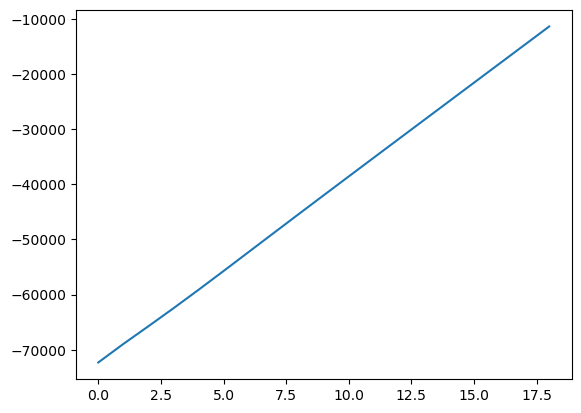

In [28]:
plt.plot(Qs_ts_oldmod)

In [29]:
result = res_load_ts_oldmod_scipy[ov2]
test = get_Qs_mixed_scipy(obs, result, M, Wv)

0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


In [ ]:
M = 20
gamma_true = res_load_ts_oldmod_scipy[ov2]['gamma_true_full']
obs = sample_obs(gamma_true, res_load_ts_oldmod_scipy[ov2])

result = res_load_ts_oldmod_scipy[ov2]
test = get_Qs_real_scipy(obs, result, M, Wv)

0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


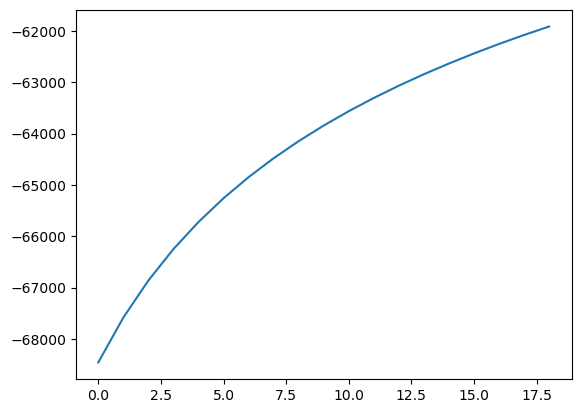

In [ ]:
plt.plot(test[2])

yesssss... next do:
- jax - should be able to 
- repeat with single-target
- do multi-target and compare cross-specs
- identify bug / problem

In [ ]:
def get_Qs_real_scipy(data, model_load, M, Wv):
    Qs = []
    # TODO option to add init as gamma_0
    # gamma_init = model_load['gamma_init']

    track = model_load['track'][0]
    em_iters = len(track)

    ocfg = model_load['cfg']['obs']
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    As = []
    Bs = []
    for r in range(1, em_iters):
        # print(r)
        gamma_r = track[r-1]['gamma_rplus1']
        J = gamma_r.shape[0]
        # gamma_r_inv = jnp.stack([jnp.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = jnp.linalg.inv(gamma_r)
        sig_r = track[r]['Sig_complex']
        mus_r = track[r]['mus']
        Ups_invs_r = track[r]['Ups_invs']

        gamma_real_r = jnp.stack([quick_conv_cov_c2r(gamma_r[j,:,:],K) for j in range(J)])
        gamma_real_r_inv = jnp.stack([quick_conv_inv_cov_c2r(gamma_r_inv[j,:,:],K) for j in range(J)])

        sig_real_r = jnp.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = jnp.stack([quick_conv_cov_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r = sig_real_r.at[l,:,:,:].set(sig_real_rl)


        # A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        A, B, Q = Q_func_real_new(mus_r, Ups_invs_r, M, gamma_real_r, gamma_real_r_inv, sig_real_r, Wv, obs_var, data)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return jnp.array(Qs) 
    return As, Bs, jnp.array(Qs) 


In [ ]:
def get_Qs_real_jax(data, model_load, M, Wv):
    Qs = []
    # TODO option to add init as gamma_0
    # gamma_init = model_load['gamma_init']

    track = model_load['track'][0]
    em_iters = len(track)

    ocfg = model_load['cfg']['obs']
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    As = []
    Bs = []
    for r in range(1, em_iters):
        # print(r)
        gamma_r = track[r-1]['gamma_rplus1']
        J = gamma_r.shape[0]
        # gamma_r_inv = jnp.stack([jnp.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = jnp.linalg.inv(gamma_r)
        sig_r = track[r]['Sig_complex']
        mus_r = track[r]['mus']
        Ups_invs_r = track[r]['Ups_invs']

        gamma_real_r = jnp.stack([quick_conv_cov_c2r(gamma_r[j,:,:],K) for j in range(J)])
        gamma_real_r_inv = jnp.stack([quick_conv_inv_cov_c2r(gamma_r_inv[j,:,:],K) for j in range(J)])

        sig_real_r = jnp.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = jnp.stack([quick_conv_cov_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r = sig_real_r.at[l,:,:,:].set(sig_real_rl)


        # A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        A, B, Q = Q_func_jax(mus_jax_r, Ups_jax_r, M, gamma__r, gamma_real_r_inv, sig_real_r, Wv, obs_var, data)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return jnp.array(Qs) 
    return As, Bs, jnp.array(Qs) 
